## Code

In [569]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm
from scipy.linalg import hankel, eigh, lstsq, toeplitz, convolution_matrix
from scipy import signal
from scipy.interpolate import approximate_taylor_polynomial
from acoustics.cepstrum import complex_cepstrum, real_cepstrum, minimum_phase
import cmath
from matplotlib import rc
from collections import defaultdict

In [570]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [571]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [572]:
def plot_zpk(zeros, poles, k):
    ''' With given zeros poles and system gain (for example scipy.tf2zpk)
    plots circle with 'x' on poles and 'o' on zeros   '''
    
    fig = plt.figure(figsize=(5, 5))
    
    z_test = np.exp(1j * np.linspace(0, 2*np.pi, 10000))
    plt.plot(np.real(z_test), np.imag(z_test), color='grey')
    plt.scatter(zeros.real, zeros.imag, 60.0, color="none", edgecolor="slateblue")
    plt.plot(poles.real, poles.imag, 'x', markersize=9.0, alpha=0.6, color='slateblue')
    
    plt.grid(True) 
    
    sc = max(np.max(zeros.real), np.max(zeros.imag), np.max(poles.real), np.max(poles.imag))
    if sc > 1.5:
        sc = 2.0
        plt.xlim([-sc, sc])
        plt.ylim(-sc, sc)
    else:
        plt.xlim([-1.5, 1.5])
        plt.ylim(-1.5, 1.5)
        
    #fig.savefig("Zeros poles plot ex.1 Prony.pdf", bbox_inches = 'tight')
        
    plt.show()
    
    mark_overlapping(zeros)
    mark_overlapping(poles)

def mark_overlapping(items):
    """
    Given `items` as a list of complex coordinates, make a tally of identical 
    values, and, if there is more than one, plot a superscript on the graph.
    """
    d = defaultdict(int)
    for i in items:
        d[i] += 1
    for item, count in d.items():
        if count > 1:
            plt.text(item.real, item.imag, r' ${}^{' + str(count) + '}$', fontsize=13)

In [573]:
def z_func_br(seq, ln, z):
    ''' Polynomial sum with weights 'seq' of length 'ln'
        with possibility of matrix coefficients '''
    
    z_degr = np.power(np.tile(z, (ln, 1)).transpose(), np.arange(0, -ln, -1))
    return np.sum(z_degr * seq, axis=1)

In [574]:
def z_func(seq, ln, z):
    ''' Polynomial sum with weights 'seq' of length 'ln' '''
    
    z_degr = np.power(z, np.arange(0, -ln, -1))
    return np.sum(z_degr * seq)

In [575]:
def invfreq(H, F, nB, nA, W, plane='z'):
    '''  Fit filter B(z)/A(z) or B(s)/A(s) to complex frequency response at 

     frequency points F. A and B are real polynomial coefficients of order 
     nA and nB respectively.  Optionally, the fit-errors can be weighted vs 
     frequency according to the weights W. Also, the transform plane can be
     specified as either 's' for continuous time or 'z' for discrete time. 'z'
     is chosen by default.  Eventually, Steiglitz-McBride iterations will be
     specified by iter and tol.
    
     H: desired complex frequency response
         It is assumed that A and B are real polynomials, hence H is one-sided.
     F: vector of frequency samples in radians
     nA: order of denominator polynomial A
     nB: order of numerator polynomial B
     plane='z': F on unit circle (discrete-time spectra, z-plane design)
     plane='s': F on jw axis     (continuous-time spectra, s-plane design)
     H(k) = spectral samples of filter frequency response at points zk,
     where zk=exp(sqrt(-1)*F(k)) when plane='z' (F(k) in [0,.5])
      and zk=(sqrt(-1)*F(k)) when plane='s' (F(k) nonnegative)
      Matlab analogue on Python '''

    n = max(nA,nB)
    m = n+1
    mA = nA+1  
    mB = nB+1  
    nF = len(F)

    if nF != len(H):
        print('invfreqz: length of H and F must be the same')
        return

    W = np.ones(nF)
    if plane != 'z' and plane != 's':
        print('invfreqz: Error in plane argument')

    Ruu = np.zeros((mB,mB))
    Ryy = np.zeros((nA,nA))
    Ryu = np.zeros((nA,mB))
    Pu = np.zeros(mB)  
    Py = np.zeros(nA)
        
    s = 1j*F;
    if plane == 'z':
        if np.max(F) > np.pi or  np.min(F) < 0:
            print('hey, you frequency is outside the range 0 to pi, making my own')
            F = np.linspace(0, np.pi, len(H))
            s = 1j*F
            
        s = np.exp(-s)
        
    for k in range(nF):
        Zk = (s[k] ** np.arange(0, n + 1))
        Hk = H[k]
        aHks = Hk * np.conj(Hk)
        Rk = (W[k] * Zk[:, None]) @ (Zk[:, None]).conj().T
        rRk = np.real(Rk)
        Ruu = Ruu + rRk[:mB, :mB]  
        Ryy = Ryy + aHks * rRk[1:mA, 1:mA]
        Ryu = Ryu + np.real(Hk * Rk[1:mA, :mB])
        Pu = Pu + W[k] * np.real(np.conj(Hk) * Zk[:mB])
        Py = Py + (W[k] * aHks) * np.real(Zk[1:mA])


    R = np.vstack((np.hstack((Ruu, -Ryu.conj().T)), np.hstack((-Ryu, Ryy)) )) #???
    
    P = np.hstack((Pu, -Py))

    Theta = lstsq(R, P)[0]

    B = Theta[1: mB].conj().T

    A = np.concatenate([[1], Theta[mB + 1:mB + nA].conj().T])

    if plane == 's':
        B = B[mB: -1: 1]
        A = A[mA: -1: 1]


    return B, A

In [576]:
# order = 12
# fc = 1/2
# n = 128
# B, A = signal.butter(order,fc)
# w, H = signal.freqz(B,A,n)
# Bh, Ah = invfreq(H, w, order, order, np.ones(len(H)))  # somewhere mistake
# wh, Hh = signal.freqz(Bh,Ah,n)
# plt.xlabel("Frequency (rad/sample)");
# plt.ylabel("Magnitude");
# plt.plot(np.linspace(0, np.pi, len(H)), np.abs(H), label='Original')
# plt.plot(np.linspace(0, np.pi, len(H)), np.abs(Hh), label='Measured')
# plt.legend()
# err = np.linalg.norm(H-Hh)
# print('L2 norm of frequency response error = %f',err)
# plt.show()

In [577]:
def prony(x, m, n):
    """Model a signal using Prony's method
 
    Usage: [b,a,err] = prony(x,m,n)
 
    The input sequence x is modeled as the unit sample response of
    a filter having a system function of the form
        H(z) = B(z)/A(z) 
    The polynomials B(z) and A(z) are formed from the vectors
        b=[b(0), b(1), ... b(m)]
        a=[1   , a(1), ... a(n)]
    The input m defines the number of zeros in the model
    and n defines the number of poles. The modeling error is 
    returned in err.
 
    """
    x = x.copy()
    H = toeplitz(x, np.zeros(n+1))
    H1 = H[:m+1, :]
    h1 = H[m+1:, 0]  
    H2 = H[m+1:, 1:]
    
    a1 = np.concatenate([[1.0], lstsq(H2, -h1)[0]])
    b1 = H1 @ a1
    
    z_test = np.exp(1j * np.linspace(0, 2*np.pi, 1000))
    ans1 = z_func_br(x, len(x), z_test)
    ans2 = z_func_br(b1, len(b1), z_test) / z_func_br(a1, len(a1), z_test)
    err1 = np.linalg.norm(ans1-ans2)
        
#     ans1 = np.fft.fft(x, n=512)
#     ans2 = (np.fft.fft(b, n=512)/np.fft.fft(a, n=512))
#     err1 = np.linalg.norm(ans1-ans2)
    
    a2 = np.concatenate([[1.0], lstsq(H2.T @ H2, -H2.T @ h1)[0]])
    b2 = H1 @ a2
    
    ans1 = z_func_br(x, len(x), z_test)
    ans2 = z_func_br(b2, len(b2), z_test) / z_func_br(a2, len(a2), z_test)
    err2 = np.linalg.norm(ans1-ans2)
    
    if err1 < err2:
        return b1, a1, err1
    else:
        return b2, a2, err2

In [578]:
def prony1(x, p, q):
    """Model a signal using Prony's method
 
    Usage: [b,a,err] = prony(x,p,q)
 
    The input sequence x is modeled as the unit sample response of
    a filter having a system function of the form
        H(z) = B(z)/A(z) 
    The polynomials B(z) and A(z) are formed from the vectors
        b=[b(0), b(1), ... b(q)]
        a=[1   , a(1), ... a(p)]
    The input q defines the number of zeros in the model
    and p defines the number of poles. The modeling error is 
    returned in err.
 
    This comes from Hayes, p. 149, 153, etc
 
    """
    x = x[:]
    N = len(x)
    if p+q >= len(x):
        print('ERROR: model order too large')
        print ("p q len(x) " + str(p) + " " + str(q) + " " + str(len(x)))
        sys.exit(1)
 
    # This formulation uses eq. 4.50, p. 153
    # Set up the convolution matrices
    X = convolution_matrix(x, p+1)
    Xq = X[q:N+p-1, 0:p]
    xq1 = -X[q+1:N+p,0]
 
    # Solve for denominator coefficients
    if p>0:
        a = np.linalg.lstsq(Xq, xq1, rcond=-1)[0]
        a = np.insert(a, 0, 1) # a(0) is 1
    else:
        # all-zero model
        a = np.array(1)
    
 
    # Solve for the model error
    err = np.dot(x[q+1:N].conj().T,X[q+1:N, 0:p+1])
    err = np.dot(err, a)
 
    # Solve for numerator coefficients
    if q>0:
        # (This is the same as for Pad?)
        b = np.dot(X[0:q+1,0:p+1], a)
    else:
        # all-pole model
        # b(0) is x(0), but a better solution is to match energy
        b = np.sqrt(err)
 
    return (b,a)

In [579]:
def cf_algo(h, k, m, n, L=0, sp='slow'):
    ''' Caratheodory-Fejer rational approximation on unit disk algorithm with given 
        impulse response h of length k, with m zeros and n poles. L is needed if you want to set
        a specific length of FFT, L=0 if you want to set it automatically. Speed sp='slow' if you want 
        to find all eigenvalues, for example for exploring the rate of decrease, sp='fast' for fast computing
        of only n max and min eignevalues.
        
        Returns all eigenvalues, n+1-th eigenvalue and corresponding eigenvector, 
        chebyshev approximate impulse response R_mn, CF-approximate impulse response R_cf,
        and coefficients b, a of numerator and denominator answer accordingly.
        
        Gutknecht M, Smith J, Trefethen L. The Caratheodory-Fejer method for recursive
        digital filter design // IEEE transactions on acoustics, speech, and signal processing.
        1983. 31, 6. 1417–1426.
        '''
    
    v = m - n + 1
    if v >= 0:
        hank = hankel(h[v:k + 1])
    else:
        hank = hankel(np.concatenate([[0]*(-v), h[:k + 1]]))
    print('Hankel shape: ', hank.shape)
    
    if sp == 'slow':
        eigval, eigvec = np.linalg.eigh(hank, UPLO='U')
    elif sp == 'fast':
        if n >= k/2 - 2:
            eigval, eigvec = np.linalg.eigh(hank, UPLO='U')    
        else:
            eigval1, eigvec1 = eigh(hank, subset_by_index=[0, n])
            eigval2, eigvec2 = eigh(hank, subset_by_index=[k-v-n, k-v])
            eigval = np.concatenate([eigval1, eigval2])
            eigvec = np.hstack([eigvec1, eigvec2])


#     if n >= k - v:
#         eign, eigvecn = 0, np.zeros(k-v)
#     else:    
    i = np.argsort(-abs(eigval))[n]
    eign, eigvecn = eigval[i], eigvec[:, i]
    print('eign: ', eign)
    
    if L == 0:
        L = int(2 ** np.ceil(np.log2((m+n)*60)))
    print('L : ', L)
    w = np.linspace(0, 2*np.pi, num=L, endpoint=False)
    #R_mn = z_func_br(h, k, np.exp(1j*w[:L//2 + 1])) - eign * np.exp(-1j*v*w[:L//2 + 1])* z_func_br(eigvecn, k - v, np.exp(1j*w[:L//2 + 1])) / z_func_br(eigvecn, k - v, np.exp(-1j*w[:L//2 + 1]))
    R_mn = np.fft.fft(h, n=L)[:L//2 + 1] - eign * np.exp(-1j*v*w[:L//2 + 1])* np.fft.fft(eigvecn, n=L)[:L//2 + 1] / np.conj(np.fft.fft(eigvecn, n=L)[:L//2 + 1])
    R_mn = np.concatenate([R_mn, np.conj(R_mn)[1:L//2][::-1]])
    print('norm cheb approx: ', np.linalg.norm(np.abs(R_mn) - np.abs(np.fft.fft(h, n=L)), np.inf))
    imp_resp = np.fft.ifft(R_mn)
    
    if v >= 0:
        R_cf = np.concatenate([imp_resp[:L//2], np.zeros(L//2)])
        b, a, err = prony(R_cf, m, n)
    else:
        R_cf = np.concatenate([np.zeros(-v), imp_resp[-v:L//2], np.zeros(L//2)])
        c, a, err = prony(R_cf, n - 1, n)
        b = c[-v:m-v+1]

    print('Prony error: ', err)
    print('ans coeffs: ', b, a)
    
    return eigval, eign, eigvecn, R_mn, R_cf, b, a

### Examples where taken from 
### Gutknecht M, Smith J, Trefethen L. The Caratheodory-Fejer method for recursive digital filter design // IEEE transactions on acoustics, speech, and signal processing. 1983

##  Example 1

In [580]:
def h1(w, var='db'):   # desired magnitude frequency response
    if var == 'hz':
        if 0 <= w < 0.25:
            return 1.0
        if w - 0.25 < 1e-5:
            return 0.5
        if 0.25 < w < 0.75:
            return 0 
        if w - 0.75 < 1e-5:
            return 0.5
        if 0.75 < w <= 1:
            return 1
    elif var == 'db':
        if 0 <= w < np.pi/2:
            return 0
        if w - np.pi/2 < 1e-5:
            return -30
        if np.pi/2 < w < 3*np.pi/2:
            return -60  
        if w - 3/2*np.pi < 1e-5:
            return -30 #-30
        if 3/2*np.pi < w <= 2*np.pi:
            return 0 #0

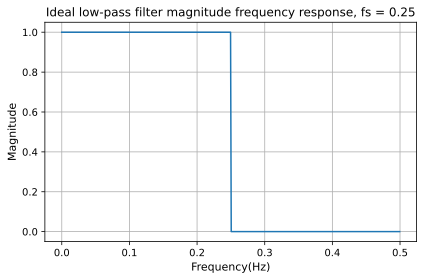

In [581]:
fig = plt.figure(figsize=(6,4))

plt.title('Ideal low-pass filter magnitude frequency response, fs = 0.25', fontsize=12)

w1_plt =  np.linspace(0, 0.5, 1000, endpoint=False)
y1 = np.vectorize(h1, otypes=[float])
h_transf1 = y1(w1_plt, 'hz')
plt.plot(w1_plt, h_transf1)

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.tight_layout()

#fig.savefig("Ideal low-pass filter magnitude frequency response.eps", bbox_inches = 'tight', format='eps')

plt.show()

In [582]:
w1 =  np.linspace(0, 2*np.pi, 256, endpoint=False)  # equally spaced points
y1 = np.vectorize(h1, otypes=[float]) # corresponding values
h_transf1 = np.fft.fft(np.exp(y1(w1, 'db')/20), n=256)  # fourier coefficients of transfer function (impulse response)
min_p = minimum_phase(h_transf1)/256 

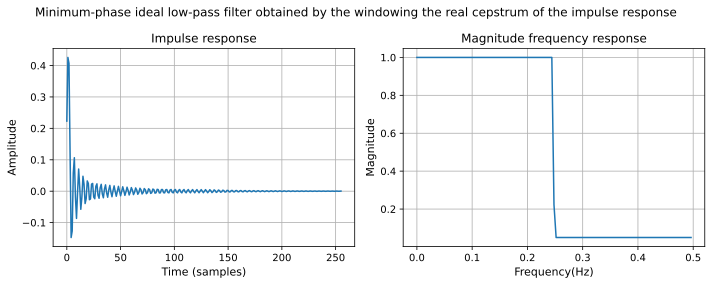

In [583]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Minimum-phase ideal low-pass filter obtained by the windowing the real cepstrum of the impulse response', fontsize=12,)

plt.subplot(1, 2, 1) 
plt.title('Impulse response',fontsize=12)

plt.plot(min_p)
plt.grid(True) 

plt.ylabel('Amplitude',  fontsize=11)
plt.xlabel('Time (samples)',  fontsize=11)

#fig.savefig("Minimum-phase ideal low-pass filter.pdf", bbox_inches = 'tight')

plt.subplot(1, 2, 2) 
plt.title('Magnitude frequency response',fontsize=12)

#plt.plot(np.linspace(0, 1, 256, endpoint=False), np.abs(np.fft.fft(min_p)))
plt.plot(np.linspace(0, 0.5, 129, endpoint=False), np.abs(np.fft.fft(min_p))[:129])
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

#fig.savefig("Minimum-phase reconstructed low-pass filter.pdf", bbox_inches = 'tight')

plt.tight_layout()

#fig.savefig('Minimum-phase low-pass filter.pdf', bbox_inches='tight')

plt.show()

In [584]:
w1_plt =  np.linspace(0, 1, 256, endpoint=False)  # equally spaced points
np.linalg.norm(y1(w1_plt, 'hz') - np.abs(np.fft.fft(min_p))) # error of reconstructing

0.6841895518608097

In [585]:
hamm = np.concatenate([signal.windows.hamming(160, sym=False)[80:], np.zeros(256-80)]) # half of hamming window
new_sig = (min_p*hamm)  # new signal

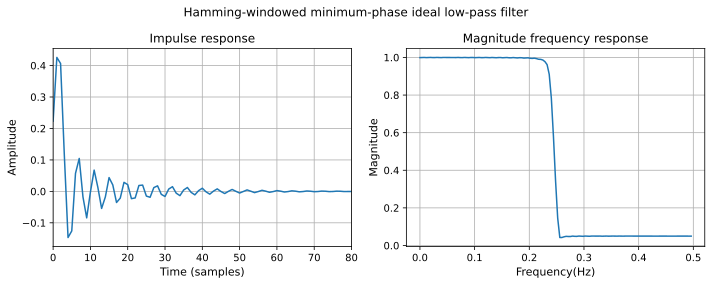

In [586]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Hamming-windowed minimum-phase ideal low-pass filter', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('Impulse response',fontsize=12)

plt.plot(new_sig)
plt.grid(True) 

plt.ylabel('Amplitude',  fontsize=11)
plt.xlabel('Time (samples)',  fontsize=11)

plt.xlim(0, 80)

plt.subplot(1, 2, 2) 
plt.title('Magnitude frequency response',fontsize=12)

#plt.plot(np.linspace(0, 1, 256, endpoint=False), np.abs(np.fft.fft(new_sig)))
plt.plot(np.linspace(0, 0.5, 129, endpoint=False), np.abs(np.fft.fft(new_sig))[:129])
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.tight_layout()

#fig.savefig("Hamming-windowed minimum-phase low-pass filter.pdf", bbox_inches = 'tight')

plt.show()

In [587]:
k = 79    # approximation with 6 zeros, 7 poles
m = 6
n = 7

%time
eigval, eigl, eigv, R_mn, R_cf, b, a = cf_algo(new_sig[:80], k, m, n, L=512, sp='slow')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs
Hankel shape:  (80, 80)
eign:  -0.005086232005157996
L :  512
norm cheb approx:  0.005086232005157995
Prony error:  3.85225524990242e-05
ans coeffs:  [0.22319374+0.j 0.28140973+0.j 0.59103995+0.j 0.47531322+0.j
 0.43945812+0.j 0.19139893+0.j 0.08045497+0.j] [ 1.        +0.j -0.64415788+0.j  2.04932368+0.j -1.11483838+0.j
  1.3319678 +0.j -0.55649076+0.j  0.26863808+0.j -0.06253411+0.j]


In [588]:
b_pr, a_pr, err = prony(new_sig[:80], m, n)
b_pr, a_pr, err

(array([0.22309153, 0.20999947, 0.4513636 , 0.27632915, 0.23734557,
        0.07567514, 0.02224163]),
 array([ 1.        , -0.96674888,  2.04640738, -1.4294273 ,  1.22816742,
        -0.54546223,  0.19693548, -0.03349308]),
 0.23061676567840558)

In [589]:
# z_test = np.exp(1j * np.linspace(0, 2*np.pi, 10000))
# ans1 = z_func_br(new_sig[:80], 80, z_test)
# ans2 = z_func_br(b, len(b), z_test) / z_func_br(a, len(a), z_test)
# err1 = np.linalg.norm(ans1-ans2, np.inf)
# err1

In [590]:
# ans3 = np.fft.fft(new_sig[:80], n=256)
# ans4 = (np.fft.fft(b, n=256)/np.fft.fft(a, n=256))
# err2 = np.linalg.norm(ans3-ans4, np.inf)
# err2
#same methods of evaluating error

In [591]:
_, ans5 = signal.freqz(b, a, worN=1024)
_, ans6 = signal.freqz(new_sig[:80], worN=1024)
np.linalg.norm(np.abs(ans5) - np.abs(ans6), np.inf)

0.006059869073585709

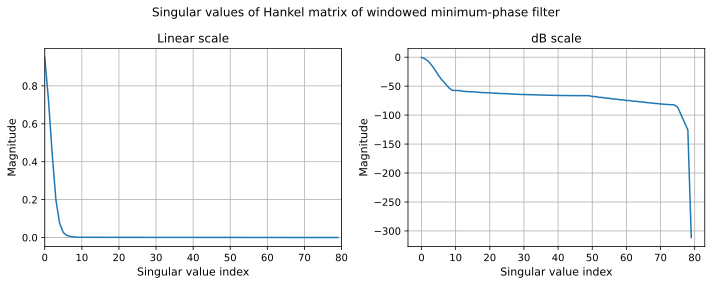

In [592]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Singular values of Hankel matrix of windowed minimum-phase filter', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('Linear scale',fontsize=12)

plt.plot(np.sort(np.abs(eigval))[::-1])
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Singular value index',  fontsize=11)

plt.xlim(0, 80)

plt.subplot(1, 2, 2) 
plt.title('dB scale',fontsize=12)

plt.plot(20*np.log10(np.sort(np.abs(eigval))[::-1]))
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Singular value index',  fontsize=11)


plt.tight_layout()

#fig.savefig("Singular values of Hankel matrix of minimum-phase filter.pdf", bbox_inches = 'tight')

plt.show()

### Magnitude frequency response error: $ |H_k(e^{iw_k})| - |R_{CF}(e^{iw_k})| $

Equation error 1 in chebyshev sense:  0.005086232005157995
Equation error 2 in chebyshev sense:  0.006029120167837715


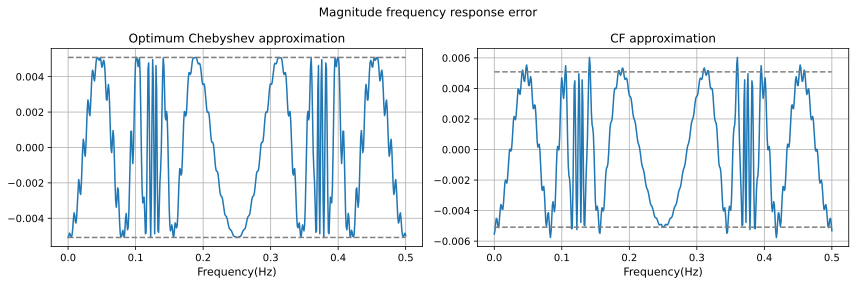

In [593]:
fig = plt.figure(figsize=(12,4))

plt.suptitle('Magnitude frequency response error', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('Optimum Chebyshev approximation',fontsize=12)

ans1 = np.abs(np.fft.fft(new_sig, n=512)) 
ans2 = np.abs(R_mn) 
print('Equation error 1 in chebyshev sense: ', np.linalg.norm(ans1 - ans2, np.inf))
plt.plot(np.linspace(0, 0.5, 512), ans1-ans2)
plt.plot(np.linspace(0, 0.5, 512), [np.max(ans1-ans2)]*512, linestyle='--', color='grey')
plt.plot(np.linspace(0, 0.5, 512), [-np.max(ans1-ans2)]*512, linestyle='--', color='grey')
plt.grid(True) 

plt.xlabel('Frequency(Hz)',  fontsize=11)


plt.subplot(1, 2, 2) 
plt.title('CF approximation',fontsize=12)

ans3 = np.abs(np.fft.fft(new_sig, n=512)) 
ans4 = np.abs(np.fft.fft(R_cf, n=512)) 
print('Equation error 2 in chebyshev sense: ', np.linalg.norm(ans3 - ans4, np.inf))
plt.plot(np.linspace(0, 0.5, 512), ans3-ans4)
plt.plot(np.linspace(0, 0.5, 512), [np.max(ans1-ans2)]*512, linestyle='--', color='grey')
plt.plot(np.linspace(0, 0.5, 512), [-np.max(ans1-ans2)]*512, linestyle='--', color='grey')

plt.grid(True) 

plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.tight_layout()

#fig.savefig("Magnitude frequency response error1.pdf", bbox_inches = 'tight')

plt.show()

In [594]:
# оценка валле пуссена

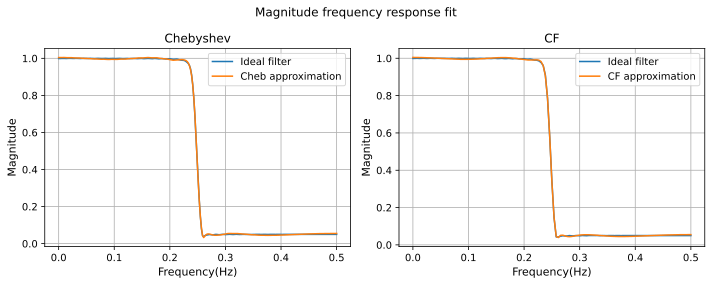

In [595]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit', fontsize=12)

plt.subplot(1, 2, 2) 
plt.title('CF',fontsize=12)

plt.plot(np.linspace(0, 0.5, 129), np.abs(np.fft.fft(new_sig))[:129], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 129), (np.abs(np.fft.fft(R_cf, n=256)))[:129], label='CF approximation')
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 1) 
plt.title('Chebyshev',fontsize=12)

plt.plot(np.linspace(0, 0.5, 256), np.abs(np.fft.fft(new_sig, n=512))[:256], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 256), np.abs(R_mn)[:256], label='Cheb approximation')


plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit.pdf", bbox_inches = 'tight')

plt.show()

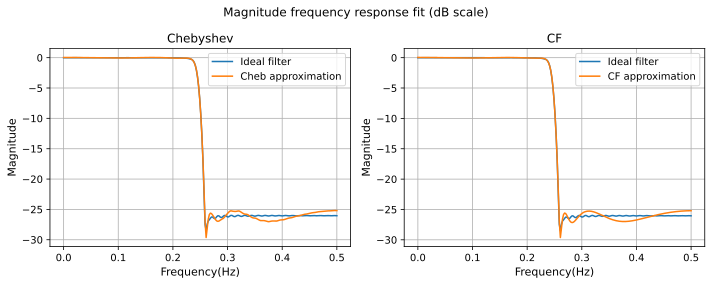

In [596]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit (dB scale)', fontsize=12)

plt.subplot(1, 2, 2) 
plt.title('CF',fontsize=12)

plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(np.fft.fft(new_sig, n=512)))[:256], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(np.fft.fft(R_cf, n=512)))[:256], label='CF approximation')
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 1) 
plt.title('Chebyshev',fontsize=12)

plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(np.fft.fft(new_sig, n=512)))[:256], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(R_mn)[:256]), label='Cheb approximation')

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit (dB scale).pdf", bbox_inches = 'tight')

plt.show()

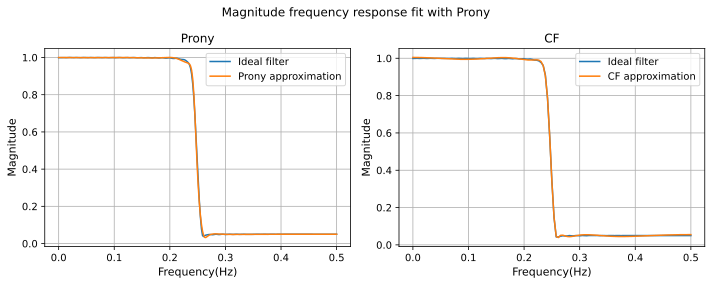

In [597]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit with Prony', fontsize=12)

plt.subplot(1, 2, 2) 
plt.title('CF',fontsize=12)

plt.plot(np.linspace(0, 0.5, 129), np.abs(np.fft.fft(new_sig))[:129], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 129), (np.abs(np.fft.fft(b, n=256)/np.fft.fft(a, n=256)))[:129], label='CF approximation')
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 1) 
plt.title('Prony',fontsize=12)


plt.plot(np.linspace(0, 0.5, 256), np.abs(np.fft.fft(new_sig, n=512))[:256], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 256), (np.abs(np.fft.fft(b_pr, n=512)/np.fft.fft(a_pr, n=512)))[:256], label='Prony approximation')

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit with Prony.pdf", bbox_inches = 'tight')

plt.show()

Frequency response error 1: 0.006059869073585709
Frequency response error 2: 0.03438260957977318


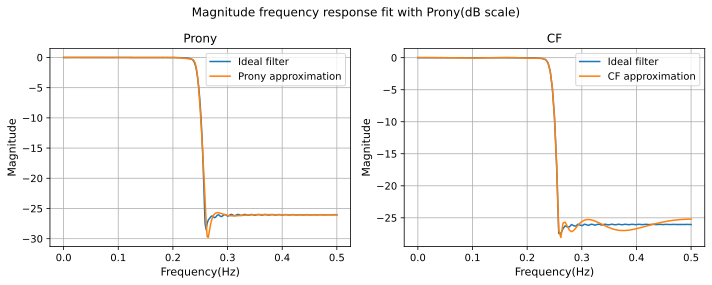

In [598]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit with Prony(dB scale)', fontsize=12)

plt.subplot(1, 2, 2) 
plt.title('CF',fontsize=12)

plt.plot(np.linspace(0, 0.5, 129), 20*np.log10(np.abs(np.fft.fft(new_sig)))[:129], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 129), 20*np.log10(np.abs(np.fft.fft(b, n=256)/np.fft.fft(a, n=256)))[:129], label='CF approximation')
_, ans5 = signal.freqz(b, a, worN=1024)
_, ans6 = signal.freqz(new_sig[:80], worN=1024)
print('Frequency response error 1: {}'.format(np.linalg.norm(np.abs(ans5) - np.abs(ans6), np.inf)))

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 1) 
plt.title('Prony',fontsize=12)

plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(np.fft.fft(new_sig, n=512)))[:256], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(np.fft.fft(b_pr, n=512)/np.fft.fft(a_pr, n=512)))[:256], label='Prony approximation')
_, ans5 = signal.freqz(b_pr, a_pr, worN=1024)
_, ans6 = signal.freqz(new_sig[:80], worN=1024)
print('Frequency response error 2: {}'.format(np.linalg.norm(np.abs(ans5) - np.abs(ans6), np.inf)))


plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit CF vs Prony.pdf", bbox_inches = 'tight')

plt.show()

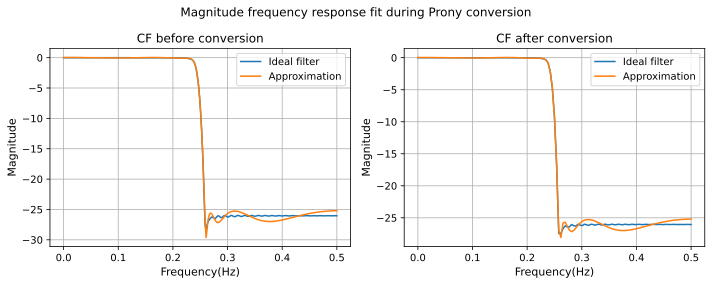

In [599]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit during Prony conversion', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('CF before conversion',fontsize=12)

plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(np.fft.fft(new_sig, n=512)))[:256], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 256), 20*np.log10(np.abs(np.fft.fft(R_cf, n=512)))[:256], label='Approximation')

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 2) 
plt.title('CF after conversion',fontsize=12)

plt.plot(np.linspace(0, 0.5, 129), 20*np.log10(np.abs(np.fft.fft(new_sig)))[:129], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 129), 20*np.log10(np.abs(np.fft.fft(b, n=256)/np.fft.fft(a, n=256)))[:129], label='Approximation')
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit (dB scale).pdf", bbox_inches = 'tight')

plt.show()

In [600]:
print('Error of Prony conversion between impulse responses: ', np.linalg.norm(R_cf - np.fft.ifft(np.fft.fft(b, n=512)/np.fft.fft(a, n=512))))

Error of Prony conversion between impulse responses:  1.2187996113122765e-06


In [601]:
_, ans5 = signal.freqz(b, a, worN=1024)
_, ans6 = signal.freqz(new_sig[:80], worN=1024)
print('Final inf norm frequency response error: {}'.format(np.linalg.norm(np.abs(ans5) - np.abs(ans6), np.inf)))

Final inf norm frequency response error: 0.006059869073585709


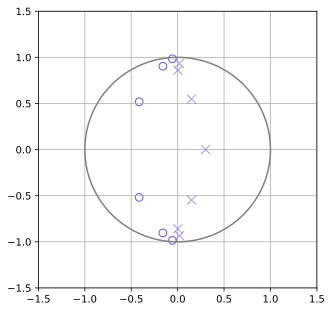

In [602]:
z, p, k = signal.tf2zpk(b, a)
plot_zpk(z, p, k)

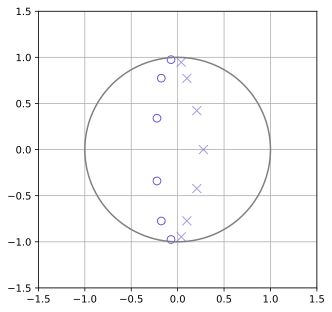

In [603]:
z, p, k = signal.tf2zpk(b_pr, a_pr)
plot_zpk(z, p, k)

In [512]:
# w = np.exp(1j * np.linspace(0, np.pi, 80))
# H = z_func_br(new_sig[:80], 80, w)

In [513]:
# w = np.exp(1j * np.linspace(0, 2*np.pi, 8000))
# H = z_func_br(new_sig[:80], 80, w)

# Bh, Ah = invfreq(H, w, m, n, np.ones(len(H)))
# wh, Hh = signal.freqz(Bh,Ah, worN=len(H))

# plt.xlabel("Frequency (rad/sample)");
# plt.ylabel("Magnitude");
# plt.plot(np.linspace(0, 2*np.pi, len(H)), np.abs(H), label='Ideal filter')
# plt.plot(np.linspace(0, 2*np.pi, len(H)), np.abs(Hh), label='Err eq approximation')
# plt.legend()
# err = np.linalg.norm(np.abs(H)-np.abs(Hh), np.inf)
# print('Inf norm of frequency response error = {}'.format(err))
# plt.show()

In [103]:
# plt.xlabel("Frequency (rad/sample)");
# plt.ylabel("Magnitude");
# plt.plot(np.linspace(0, 0.5, 129), np.abs(np.fft.fft(new_sig))[:129], label='Ideal filter')
# plt.plot(np.linspace(0, 0.5, 129), (np.abs(np.fft.fft(Bh, n=256)/np.fft.fft(Ah, n=256)))[:129], label='Err eq approximation')

# plt.legend()
# err = np.linalg.norm(H-np.abs(Hh), np.inf)
# print('Inf norm of frequency response error = {}'.format(err))
# plt.show()

In [297]:
# np.linalg.norm(np.abs(np.fft.fft(new_sig))[:129] - (np.abs(np.fft.fft(Bh, n=256)/np.fft.fft(Ah, n=256)))[:129], np.inf)

## Example 2

In [604]:
cutoff = 0.1   # Desired cutoff frequency, Hz
trans_width = 0.1  # Width of transition from pass to stop, Hz
numtaps = 21    # Size of the FIR filter.
fs = 1
taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], fs=fs)
w2, h2 = signal.freqz(taps, [1], worN=1024, fs=fs)

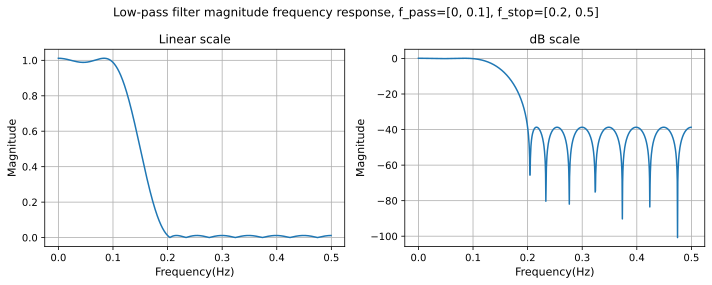

In [605]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Low-pass filter magnitude frequency response, f_pass=[0, 0.1], f_stop=[0.2, 0.5]', fontsize=12)

plt.subplot(1, 2, 1)
plt.title('Linear scale',fontsize=12)

plt.plot(w2, np.abs(h2))

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.subplot(1, 2, 2)
plt.title('dB scale',fontsize=12)

plt.plot(w2, 20*np.log10(np.abs(h2)))

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)


plt.tight_layout()

#fig.savefig("Ideal low-pass linear phase filter magnitude frequency response.pdf", bbox_inches = 'tight')

plt.show()

In [606]:
k = 20    # approximation with 6 zeros, 7 poles
m = 6
n = 7

%time
eigval, eigl, eigv, R_mn, R_cf, b, a = cf_algo(taps, k, m, n, L=256, sp='slow')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
Hankel shape:  (21, 21)
eign:  -0.011109826683695066
L :  256
norm cheb approx:  0.01110982668369509
Prony error:  0.07011072029576561
ans coeffs:  [-0.00097375+0.j  0.01135109+0.j -0.01902369+0.j -0.00478835+0.j
  0.0339024 +0.j -0.03942095+0.j  0.03660752+0.j] [  1.        +0.j  -4.22143316+0.j   8.52401334+0.j -10.5177862 +0.j
   8.50059329+0.j  -4.48271673+0.j   1.4262854 +0.j  -0.21162459+0.j]


In [607]:
_, ans5 = signal.freqz(b, a, worN=1024)
_, ans6 = signal.freqz(taps, worN=1024)
np.linalg.norm(np.abs(ans5) - np.abs(h2), np.inf)

0.016430105534185335

In [608]:
b_pr, a_pr, err = prony(taps, m, n)
b_pr, a_pr, err

(array([-0.00241346,  0.02120942, -0.04971074,  0.04764547, -0.02362735,
         0.00862945,  0.01134683]),
 array([ 1.        , -4.22705217,  8.03461877, -8.35892191,  4.31338356,
         0.02460469, -1.28195237,  0.52414348]),
 26.397518815453815)

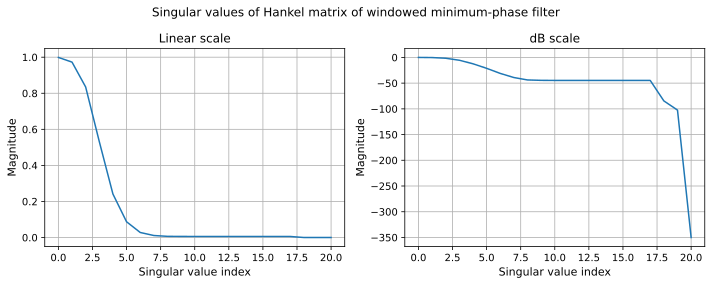

In [609]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Singular values of Hankel matrix of windowed minimum-phase filter', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('Linear scale',fontsize=12)

plt.plot(np.sort(np.abs(eigval))[::-1])
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Singular value index',  fontsize=11)

plt.subplot(1, 2, 2) 
plt.title('dB scale',fontsize=12)

plt.plot(20*np.log10(np.sort(np.abs(eigval))[::-1]))
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Singular value index',  fontsize=11)


plt.tight_layout()

#fig.savefig("Singular values of Hankel matrix of linear-phase filter.pdf", bbox_inches = 'tight')

plt.show()

Equation error 1 in chebyshev sense:  0.01110982668369509
Equation error 2 in chebyshev sense:  0.012294751858698636


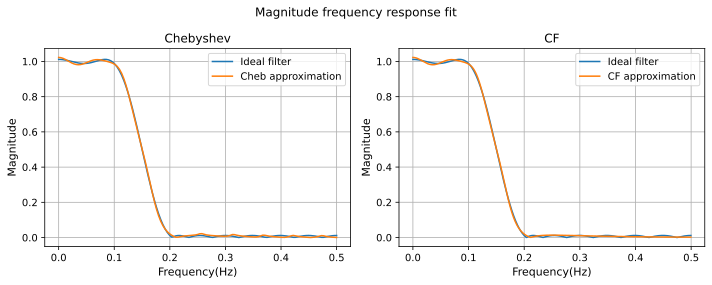

In [610]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('Chebyshev',fontsize=12)

ans3 = np.abs(np.fft.fft(taps, n=256)) 
ans4 = np.abs(R_mn)
plt.plot(np.linspace(0, 0.5, 129), ans3[:129], label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 129), np.abs(R_mn)[:129], label='Cheb approximation')

print('Equation error 1 in chebyshev sense: ', np.linalg.norm(ans3 - ans4, np.inf))

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 2) 
plt.title('CF',fontsize=12)

ans1 = np.abs(h2)
ans2 = (np.abs(np.fft.fft(R_cf, n=2048)))[:1024]
plt.plot(w2, ans1, label='Ideal filter')
plt.plot(w2, ans2, label='CF approximation')

print('Equation error 2 in chebyshev sense: ', np.linalg.norm(ans1 - ans2, np.inf))

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit ex.2.pdf", bbox_inches = 'tight')

plt.show()

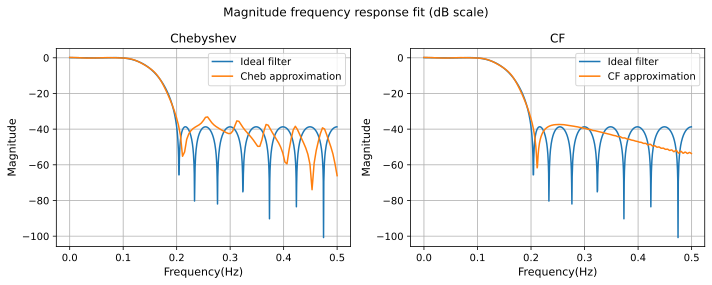

In [611]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit (dB scale)', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('Chebyshev',fontsize=12)


plt.plot(w2, 20*np.log10(np.abs(h2)), label='Ideal filter')
plt.plot(np.linspace(0, 0.5, 129), 20*np.log10(np.abs(R_mn))[:129], label='Cheb approximation')

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 2) 
plt.title('CF',fontsize=12)

plt.plot(w2, 20*np.log10(np.abs(h2)), label='Ideal filter')
plt.plot(w2, 20*np.log10((np.abs(np.fft.fft(R_cf, n=2048))))[:1024], label='CF approximation')
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit dB scale ex.2.pdf", bbox_inches = 'tight')

plt.show()

Equation error 1 in chebyshev sense:  2.6242465700033377
Equation error 2 in chebyshev sense:  0.01643010553419333


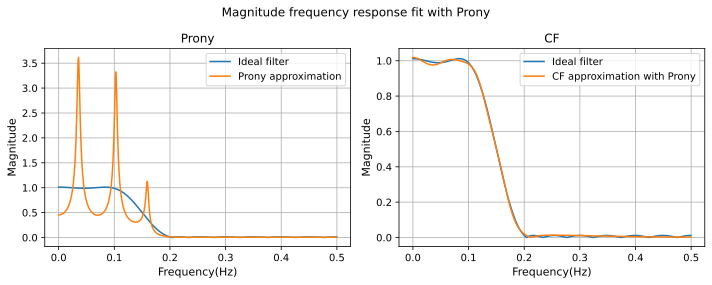

In [612]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit with Prony', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('Prony',fontsize=12)

ans1 = (np.abs(np.fft.fft(b_pr, n=2048)/np.fft.fft(a_pr, n=2048)))[:1024]
plt.plot(w2, np.abs(h2), label='Ideal filter')
plt.plot(w2, ans1, label='Prony approximation')

print('Equation error 1 in chebyshev sense: ', np.linalg.norm(np.abs(h2) - ans1, np.inf))

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.subplot(1, 2, 2) 
plt.title('CF',fontsize=12)

ans2 = (np.abs(np.fft.fft(b, n=2048)/np.fft.fft(a, n=2048)))[:1024]
plt.plot(w2, np.abs(h2), label='Ideal filter')
plt.plot(w2, ans2, label='CF approximation with Prony')

print('Equation error 2 in chebyshev sense: ', np.linalg.norm(np.abs(h2) - ans2, np.inf))

plt.grid(True) 


plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit CF vs Prony ex.2.pdf", bbox_inches = 'tight')

plt.show()

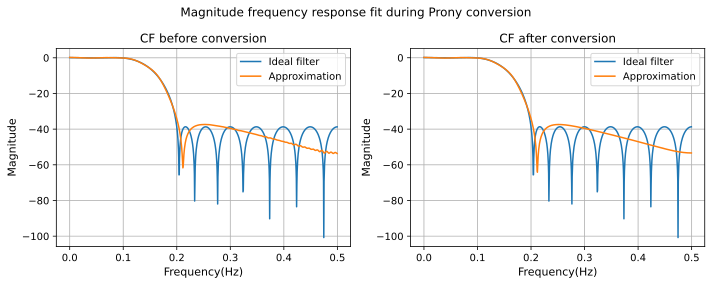

In [615]:
fig = plt.figure(figsize=(10,4))

plt.suptitle('Magnitude frequency response fit during Prony conversion', fontsize=12)

plt.subplot(1, 2, 1) 
plt.title('CF before conversion',fontsize=12)

plt.plot(w2, 20*np.log10(np.abs(h2)), label='Ideal filter')
plt.plot(w2, 20*np.log10(np.abs(np.fft.fft(R_cf, n=2048)))[:1024], label='Approximation')

plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)


plt.subplot(1, 2, 2) 
plt.title('CF after conversion',fontsize=12)

ans2 = (np.abs(np.fft.fft(b, n=2048)/np.fft.fft(a, n=2048)))[:1024]
plt.plot(w2, 20*np.log10(np.abs(h2)), label='Ideal filter')
plt.plot(w2, 20*np.log10(ans2), label='Approximation')
plt.grid(True) 

plt.ylabel('Magnitude',  fontsize=11)
plt.xlabel('Frequency(Hz)',  fontsize=11)

plt.legend(fontsize=10)

plt.tight_layout()

#fig.savefig("Magnitude frequency response fit (dB scale).pdf", bbox_inches = 'tight')

plt.show()

In [616]:
print('Error of Prony conversion between impulse responses: ', np.linalg.norm(R_cf - np.fft.ifft(np.fft.fft(b, n=256)/np.fft.fft(a, n=256))))

Error of Prony conversion between impulse responses:  0.0022143387186402855


In [617]:
_, ans5 = signal.freqz(b, a, worN=1024)
_, ans6 = signal.freqz(taps, worN=1024)
print('Final inf norm frequency response error: {}'.format(np.linalg.norm(np.abs(ans5) - np.abs(ans6), np.inf)))

Final inf norm frequency response error: 0.016430105534185335


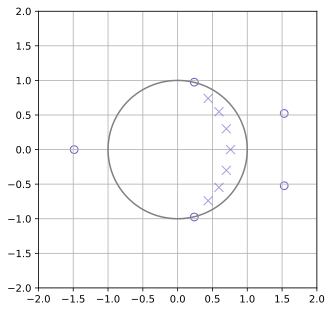

In [618]:
z, p, k = signal.tf2zpk(b, a)
plot_zpk(z, p, k)

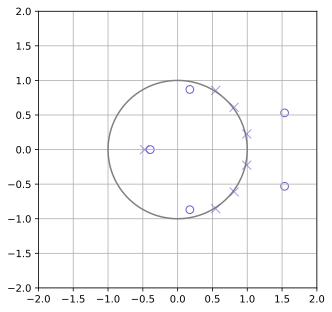

In [619]:
z, p, k = signal.tf2zpk(b_pr, a_pr)
plot_zpk(z, p, k)